# Airbnb Boston Analysis

## Business Understanding

1. What are the most expensive neighbourhoods in Boston?
2. Is there a price-sesonality?
3. Based on the reviews, are there months where people prefere to visit boston?

## Data Understanding & Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)


from datetime import datetime


df_calendar = pd.read_csv('./calendar.csv')
df_listings = pd.read_csv('./listings.csv', index_col='id')
df_reviews = pd.read_csv('./reviews.csv')

In [3]:
# remove '$' and ',' from price and convert price into float
df_calendar['price'] = df_calendar['price'].str.replace('$','')
df_calendar['price'] = df_calendar['price'].str.replace(',','')
df_calendar['price'] = df_calendar['price'].astype(float)

# convert date from dtype 'object' to 'date
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

/var/folders/7q/sn8wp6ts1zn93_q6447bhvvw0000gn/T/ipykernel_55414/1195643645.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_calendar['price'] = df_calendar['price'].str.replace('$','')


In [4]:
# share of days for which no price is available
print("The share of days for which the listings are unavailable is {}".format(df_calendar['price'].isnull().sum()/df_calendar.shape[0]))

The share of days for which the listings are unavailable is 0.5087157820748879


To work with the calendar price data, transform the data to a pivot table. **Listings for which there is no price at all available, are dropped.** Henceforth, only listings which have at least one price available are considered.

In [5]:
# transfor the calendar data into a more convenient layout
df_price = df_calendar.pivot_table(index='date',columns='listing_id',values='price')

# relevant listings
listings = df_price.columns

In [6]:
print("The share of listings for which there is no variability in the price is {}".format((df_price.std()==0).sum()/df_price.shape[1]))

The share of listings for which there is no variability in the price is 0.3465244322092223


In [7]:
#interpolate linearly for missing values, for values at the beginning of the period use a backwardfill 
df_price = df_price.interpolate(method='linear').fillna(method='bfill')

In [8]:
def listing_mean_neighbourhood(listing_id):
    neighbourhood = df_listings.loc[listing_id]['neighbourhood_cleansed']
    mean_price = df_price[listing_id].mean()

    return neighbourhood, mean_price

In [9]:
d = []

for listing in listings:
    neighbourhood, mean_price = listing_mean_neighbourhood(listing)
    d.append(
        {
            'listing_id':listing,
            'neighbourhood': neighbourhood,
            'mean_price': mean_price
        }
    )

df_listing_mean_neighbourhood = pd.DataFrame(d)

In [10]:
mean_price_by_neighbourhood = df_listing_mean_neighbourhood[['neighbourhood','mean_price']].groupby('neighbourhood').mean().sort_values(by='mean_price')
mean_price_by_neighbourhood

,mean_price
neighbourhood,
Mattapan,76.370578
Hyde Park,77.719432
Dorchester,92.450975
Roslindale,96.748932
West Roxbury,112.100308
East Boston,126.312949
Allston,128.442025
Brighton,130.020044
Longwood Medical Area,132.671575


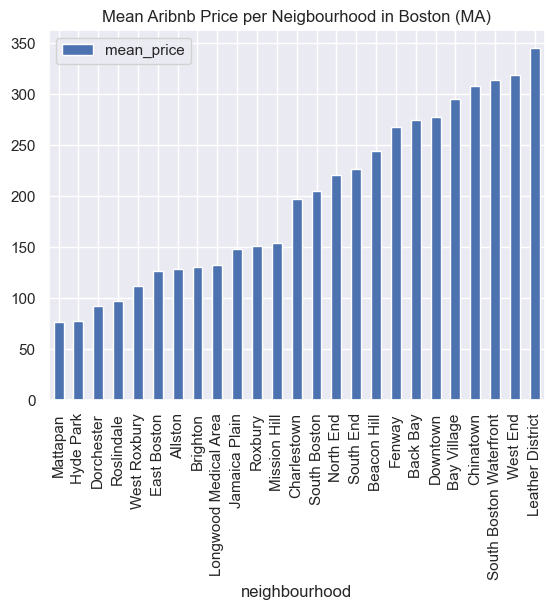

In [11]:
ax = mean_price_by_neighbourhood.plot.bar(layout='constraint')

plt.title('Mean Aribnb Price per Neigbourhood in Boston (MA)')
plt.savefig('mean_price_neighbor.jpeg',bbox_inches="tight",dpi=600);

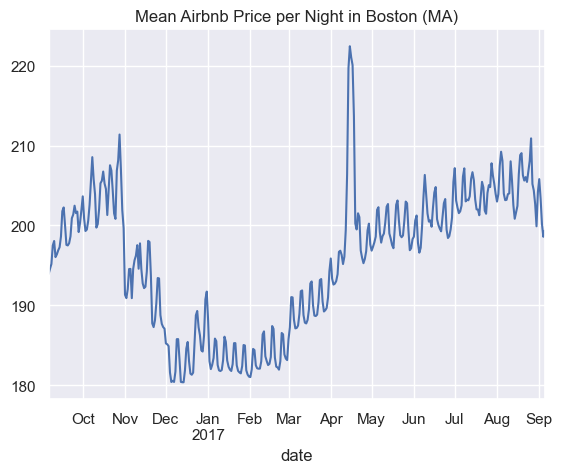

In [12]:
ax = df_price.mean(axis=1).plot(layout='constraint')

plt.title('Mean Airbnb Price per Night in Boston (MA)')
plt.savefig('mean_price_per_night.jpeg',bbox_inches="tight",dpi=600);

## Data Modeling

Adressing question #3 is more complex than questions #1 & #2. The goal is to use features of the listing (type, rooms, neigborhood, ...) and reviews (no. of reviews per listing, frequency of reviews, ...) to predict the price of a given listing on the day the `listings.csv` data has beeen scraped. To start modeling we have to decide on features we want to include in the model.

In [113]:
df_listings_red = df_listings[[
                    'last_scraped',
                    'host_since',
                    'host_response_time',
                    'host_response_rate',
                    'host_acceptance_rate',
                    'host_is_superhost',
                    'host_listings_count',
                    'host_has_profile_pic',
                    'host_identity_verified',
                    'neighbourhood_cleansed',
                    'property_type',
                    'room_type',
                    'accommodates',
                    'bathrooms',
                    'bedrooms',
                    'beds',
                    'bed_type',
                    'amenities',
                    'price',
                    'cleaning_fee',
                    'guests_included',
                    'minimum_nights',
                    'review_scores_rating',
                    'review_scores_accuracy',
                    'review_scores_cleanliness',
                    'review_scores_checkin',
                    'review_scores_communication',
                    'review_scores_location',
                    'review_scores_value',
                    'cancellation_policy',
                    'reviews_per_month']].copy()

First we have to prepare the columns that are in the wrong format, e.g., turn host_since into the date difference relative to 2016-09-07 in days, and convert numbers with '$' or '%' sign.

In [114]:
#convert last_scraped and host_since to datetime
df_listings_red[['last_scraped','host_since']] = df_listings_red[['last_scraped','host_since']].apply(pd.to_datetime)

#calculate host_since in days
df_listings_red['host_since_days'] = (df_listings_red['last_scraped'] - df_listings_red['host_since']) / np.timedelta64(1, 'D')

# drop 'last_scraped','host_since'

df_listings_red = df_listings_red.drop(['last_scraped','host_since'],axis=1)

In [115]:
#remove % sign from rate columns and convert them to dtype float
def convert_rate(df: pd.DataFrame, cols: list):
    
    """
    Remove '%' sign and convert column to float between 0 and 1
    # Parameters
    df:     dataframe of interest
    cols:   list of columns which feature rates
    """

    for col in cols:
        df[col] = df[col].str.replace('%','')
        df[col] = df[col].astype(float)/100

#remove $ sign and , as seperator and turn dollar amount columns into float
def convert_dollar(df: pd.DataFrame, cols: list):

    """
    Remove '$' and ',' sign and convert column to float
    # Parameters
    df:     dataframe of interest
    cols:   list of columns which feature rates
    """

    for col in cols:
        df[col] = df[col].str.replace('$','')
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].astype(float)

In [116]:
convert_rate(df_listings_red,['host_response_rate', 'host_acceptance_rate'])
convert_dollar(df_listings_red,['price', 'cleaning_fee'])

/var/folders/7q/sn8wp6ts1zn93_q6447bhvvw0000gn/T/ipykernel_55414/769525049.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$','')


In [117]:
df_listings_red_amen = df_listings_red[['amenities']].copy()
df_listings_red_amen['amenities'] = df_listings_red_amen['amenities'].str.replace('{','')
df_listings_red_amen['amenities'] = df_listings_red_amen['amenities'].str.replace('}','')
df_listings_red_amen['amenities'] = df_listings_red_amen['amenities'].str.replace('"','')

df_amenities = df_listings_red_amen['amenities'].str.split(',',expand=True)
df_amenities

df_amenities[0].unique()

l=[]

for col in df_amenities.columns:
    for amen in df_amenities[col].unique():
        l.append(amen)

/var/folders/7q/sn8wp6ts1zn93_q6447bhvvw0000gn/T/ipykernel_55414/2065749642.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_listings_red_amen['amenities'] = df_listings_red_amen['amenities'].str.replace('{','')
/var/folders/7q/sn8wp6ts1zn93_q6447bhvvw0000gn/T/ipykernel_55414/2065749642.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_listings_red_amen['amenities'] = df_listings_red_amen['amenities'].str.replace('}','')


In [118]:
amenities = list(set(l))
amenities.remove('')
amenities.remove(None)
amenities.remove('translation missing: en.hosting_amenity_49')
amenities.remove('translation missing: en.hosting_amenity_50')

In [119]:
l1 = []
for id in df_listings_red.index:
    l2 = []
    for amen in amenities:
        if amen in list(df_amenities.loc[id]):
            l2.append(1)
        else:
            l2.append(0)
    l1.append(l2)

In [120]:
df_amen_cat = pd.DataFrame(index=df_listings_red.index, columns=amenities, data=l1)

In [121]:
df_listings_red = pd.merge(df_listings_red, df_amen_cat, left_index=True,right_index=True).drop('amenities',axis=1)

In [130]:
#for listings where cleaning_fee is missing replace NaN with 0 because probably no fee due
df_listings_red[['cleaning_fee']] = df_listings_red[['cleaning_fee']].fillna(0)

- All variables which require special consideradtion regarding data preparation have been dealt with
- Now, for all numerical variables which have missing values at this point, we'll simpy impute them using the mean of the features column
- For the remaining categorcial variables we'll create dummy variables

In [123]:
df_listings_red_cat = df_listings_red.select_dtypes('object')

In [124]:
#Create a copy of the dataframe
df_listings_red_cat_copy = df_listings_red_cat.copy()
#Pull a list of the column names of the categorical variables
df_listings_red_cat_lst = df_listings_red_cat.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [133]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model 
    '''
    
    #drop rows with missing response values
    df = df.dropna(axis=0, subset=[response_col])
    
    #drop columns where all values are missing
    df = df.dropna(axis=1,how='all')
    
    #dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)
    
    #mean function
    fill_mean = lambda col: col.fillna(col.mean())

    #fill mean for missing values
    df = df.apply(fill_mean,axis=0)
    
    #split data
    X = df.drop(response_col,axis=1)
    y = df[response_col]
    
    #training and test data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    #instantiate linear regression model
    lm_model = LinearRegression()
    
    #fit model
    lm_model.fit(X_train,y_train)
    
    #predict response for train and test data
    y_train_preds = lm_model.predict(X_train)
    y_test_preds = lm_model.predict(X_test)
    
    #rsquare for train and test data
    train_score = r2_score(y_train,y_train_preds)
    test_score = r2_score(y_test, y_test_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [134]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_listings_red, 'price', df_listings_red_cat_lst, dummy_na=False)

In [135]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.4704392919762025.  The rsquared on the test data was 0.2789012635699426.
